In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_nftc/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.027001e-01,9.860918e-02,3.749753e-01,5.920373e-02,...,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,4.523420e-01,2.908001e-01,4.479160e-01,2.284681e-01,...,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,9.387755e-01,0.000000e+00,9.230769e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [5]:
intra_collab_fields = [
    "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)",
    "ln(1 + IntraProjectLinkIntensity)",
]

df = df.drop(intra_collab_fields, axis=1)

In [6]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [7]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6988274383294377


### Sample only PRs by first-time contributors

In [8]:
# Filters data
df = df[df[ftc_key] == False]
df = df.drop([ftc_key], axis=1)
independent_fields.remove(ftc_key)
print(f"{len(df)=}")

# Recalculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

# Resets indices.
df = df.reset_index(drop=True)
print(independent_fields)

df.describe()

len(df)=789136
class_imbalance=5.992910818091592
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosys

,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity)
count,7.891360e+05,789136.000000,789136.0,789136.0,789136.0,789136.000000,789136.000000,789136.000000,789136.000000,789136.000000,...,789136.000000,789136.000000,789136.000000,789136.000000,789136.000000,789136.000000,789136.000000,789136.000000,789136.000000,789136.000000
mean,9.085054e+05,9515.836971,0.0,0.0,0.0,0.774904,0.477071,0.139012,0.439124,0.077807,...,0.101676,0.170156,0.016163,0.027731,0.091470,0.155922,0.012435,0.022729,0.072194,0.026768
std,5.242908e+05,5780.844539,0.0,0.0,0.0,0.362112,0.457017,0.336996,0.456631,0.259210,...,0.131815,0.190218,0.063896,0.094008,0.124408,0.183622,0.060248,0.093753,0.103635,0.097181
min,0.000000e+00,43.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.549825e+05,4466.000000,0.0,0.0,0.0,0.750000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.080010e+05,9653.000000,0.0,0.0,0.0,0.977273,0.538462,0.000000,0.042553,0.000000,...,0.000000,0.122888,0.000000,0.000000,0.000000,0.077533,0.000000,0.000000,0.020448,0.000000
75%,1.362738e+06,14470.000000,0.0,0.0,0.0,1.000000,0.967742,0.000000,0.960000,0.000000,...,0.178763,0.310134,0.000000,0.000000,0.141667,0.277955,0.000000,0.000000,0.114628,0.000000
max,1.815965e+06,20094.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.854348,0.886728,1.000000,1.000000,0.854348,0.886162,0.999796,1.000000,0.922599,1.000000


## Model Creation

In [9]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [10]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [11]:
from wmutils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [12]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43

random_state=43

random_state=43

random_state=43

random_state=43

metrics={'accuracy': 0.9278830618335265, 'precision': 0.9407949596960993, 'recall': 0.9772352065858733, 'f1': 0.9586689228936838}


Confusion matrix:
[[ 14443   8307]
 [  3075 132002]]


Classification report:

              precision    recall  f1-score   support

       False       0.82      0.63      0.72     22750
        True       0.94      0.98      0.96    135077

    accuracy                           0.93    157827
   macro avg       0.88      0.81      0.84    157827
weighted avg       0.92      0.93      0.92    157827


metrics={'accuracy': 0.9278898547786197, 'precision': 0.9416716519955559, 'recall': 0.9764350542414687, 'f1': 0.9587383304631559}


Confusion matrix:
[[ 14225   8190]
 [  3191 132222]]


Classification report:

              precision    recall  f1-score   support

       False       0.82      0.63      0.71     22415
        True       0.94      0.98      0.96    135413

    accuracy                           0.93    157828
   macro avg       0.88      0.81      0.84    157828
weighted avg       0.92      0.93      0.92    157828


metrics={'accuracy': 0.9284342983139767, 'precision': 0.9408937497329859, 'recall': 0.9778443778443778, 'f1': 0.9590132703382358}


Confusion matrix:
[[ 14391   8301]
 [  2994 132141]]


Classification report:

              precision    recall  f1-score   support

       False       0.83      0.63      0.72     22692
        True       0.94      0.98      0.96    135135

    accuracy                           0.93    157827
   macro avg       0.88      0.81      0.84    157827
weighted avg       0.92      0.93      0.92    157827


metrics={'accuracy': 0.9298092214893523, 'precision': 0.9421015926331819, 'recall': 0.9782602270040198, 'f1': 0.9598404930215696}


Confusion matrix:
[[ 14363   8136]
 [  2942 132386]]


Classification report:

              precision    recall  f1-score   support

       False       0.83      0.64      0.72     22499
        True       0.94      0.98      0.96    135328

    accuracy                           0.93    157827
   macro avg       0.89      0.81      0.84    157827
weighted avg       0.93      0.93      0.93    157827


metrics={'accuracy': 0.9288334695584406, 'precision': 0.9419842869658743, 'recall': 0.977189936084531, 'f1': 0.9592642024023675}


Confusion matrix:
[[ 14347   8145]
 [  3087 132248]]


Classification report:

              precision    recall  f1-score   support

       False       0.82      0.64      0.72     22492
        True       0.94      0.98      0.96    135335

    accuracy                           0.93    157827
   macro avg       0.88      0.81      0.84    157827
weighted avg       0.93      0.93      0.92    157827



Performance metrics full model:
f1_scores=[0.9586689228936838, 0.9587383304631559, 0.9590132703382358, 0.9598404930215696, 0.9592642024023675]
f1_mean=0.9591050438238027, f1_std=0.00042410364366378536


### Control + Intra-project Model

In [13]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45

random_state=45

random_state=45

random_state=45

random_state=45

metrics={'accuracy': 0.9253681222596751, 'precision': 0.9413241829972107, 'recall': 0.9737723790828451, 'f1': 0.9572733900893418}


Confusion matrix:
[[ 14097   8225]
 [  3554 131952]]


Classification report:

metrics={'accuracy': 0.9244235777148396, 'precision': 0.9400661093302682, 'recall': 0.9738700826128438, 'f1': 0.956669572798605}


Confusion matrix:
[[ 14223   8395]
 [  3533 131676]]


Classification report:

              precision    recall  f1-score   support

       False       0.80      0.63      0.71     22322
        True       0.94      0.97      0.96    135506

    accuracy                           0.93    157828
   macro avg       0.87      0.80      0.83    157828
weighted avg       0.92      0.93      0.92    157828


              precision    recall  f1-score   support

       False       0.80      0.63      0.70     22618
        True       0.94      0.97      0.96    135209

    accuracy                           0.92    157827
   macro avg       0.87      0.80      0.83    157827
weighted avg       0.92      0.92      0.92    157827


metrics={'accuracy': 0.9249241257832944, 'precision': 0.9401384329955759, 'recall': 0.9744103660205161, 'f1': 0.9569676521966509}


Confusion matrix:
[[ 14227   8389]
 [  3460 131751]]


Classification report:

              precision    recall  f1-score   support

       False       0.80      0.63      0.71     22616
        True       0.94      0.97      0.96    135211

    accuracy                           0.92    157827
   macro avg       0.87      0.80      0.83    157827
weighted avg       0.92      0.92      0.92    157827


metrics={'accuracy': 0.9260202626926952, 'precision': 0.9408872619327953, 'recall': 0.9749199612560723, 'f1': 0.9576013304961037}


Confusion matrix:
[[ 14296   8284]
 [  3392 131855]]


Classification report:

              precision    recall  f1-score   support

       False       0.81      0.63      0.71     22580
        True       0.94      0.97      0.96    135247

    accuracy                           0.93    157827
   macro avg       0.87      0.80      0.83    157827
weighted avg       0.92      0.93      0.92    157827


metrics={'accuracy': 0.9255640669847365, 'precision': 0.9411226248453513, 'recall': 0.9739851237834437, 'f1': 0.9572719205086053}


Confusion matrix:
[[ 14479   8233]
 [  3515 131600]]


Classification report:

              precision    recall  f1-score   support

       False       0.80      0.64      0.71     22712
        True       0.94      0.97      0.96    135115

    accuracy                           0.93    157827
   macro avg       0.87      0.81      0.83    157827
weighted avg       0.92      0.93      0.92    157827



Performance metrics control + intra model:
f1_scores=[0.9572733900893418, 0.956669572798605, 0.9569676521966509, 0.9576013304961037, 0.9572719205086053]
f1_mean=0.9571567732178614, f1_std=0.0003154744287910175


### Collaboration and Ecosystem Model

In [14]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

random_state=47

random_state=47

random_state=47

random_state=47

random_state=47

metrics={'accuracy': 0.856120942551021, 'precision': 0.869918059652573, 'recall': 0.9788743822379582, 'f1': 0.9211856171039844}


Confusion matrix:
[[  2413  19844]
 [  2864 132706]]


Classification report:

              precision    recall  f1-score   support

       False       0.46      0.11      0.18     22257
        True       0.87      0.98      0.92    135570

    accuracy                           0.86    157827
   macro avg       0.66      0.54      0.55    157827
weighted avg       0.81      0.86      0.82    157827


metrics={'accuracy': 0.8548473961996363, 'precision': 0.8683873930012135, 'recall': 0.9789697857047784, 'f1': 0.9203688705511854}


Confusion matrix:
[[  2528  20065]
 [  2844 132390]]


Classification report:

              precision    recall  f1-score   support

       False       0.47      0.11      0.18     22593
        True       0.87      0.98      0.92    135234

    accuracy                           0.85    157827
   macro avg       0.67      0.55      0.55    157827
weighted avg       0.81      0.85      0.81    157827


metrics={'accuracy': 0.8550130521833895, 'precision': 0.8683609890470256, 'recall': 0.9792028755056911, 'f1': 0.9204570340064169}


Confusion matrix:
[[  2546  20071]
 [  2812 132399]]


Classification report:

              precision    recall  f1-score   support

       False       0.48      0.11      0.18     22617
        True       0.87      0.98      0.92    135211

    accuracy                           0.86    157828
   macro avg       0.67      0.55      0.55    157828
weighted avg       0.81      0.86      0.81    157828


metrics={'accuracy': 0.85337109620027, 'precision': 0.8670470943198216, 'recall': 0.9787356917563785, 'f1': 0.919512246019435}


Confusion matrix:
[[  2495  20270]
 [  2872 132190]]


Classification report:

              precision    recall  f1-score   support

       False       0.46      0.11      0.18     22765
        True       0.87      0.98      0.92    135062

    accuracy                           0.85    157827
   macro avg       0.67      0.54      0.55    157827
weighted avg       0.81      0.85      0.81    157827


metrics={'accuracy': 0.8541694386891977, 'precision': 0.86816388945403, 'recall': 0.978344957141061, 'f1': 0.919967174579772}


Confusion matrix:
[[  2528  20088]
 [  2928 132283]]


Classification report:

              precision    recall  f1-score   support

       False       0.46      0.11      0.18     22616
        True       0.87      0.98      0.92    135211

    accuracy                           0.85    157827
   macro avg       0.67      0.55      0.55    157827
weighted avg       0.81      0.85      0.81    157827



Performance metrics non-control model:
f1_scores=[0.9211856171039844, 0.9203688705511854, 0.9204570340064169, 0.919512246019435, 0.919967174579772]
f1_mean=0.9202981884521588, f1_std=0.0005558836519595848


## Feature Explanation and Evaluation

### Model Creation

In [15]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49


metrics={'accuracy': 0.9277884785969537, 'precision': 0.9405859644383144, 'recall': 0.977538052312694, 'f1': 0.9587060728920966}

Confusion matrix:
[[ 14131   8357]
 [  3040 132300]]

Classification report:


              precision    recall  f1-score   support

       False       0.82      0.63      0.71     22488
        True       0.94      0.98      0.96    135340

    accuracy                           0.93    157828
   macro avg       0.88      0.80      0.84    157828
weighted avg       0.92      0.93      0.92    157828



### Mean decrease in Impurity

/tmp/ipykernel_118284/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


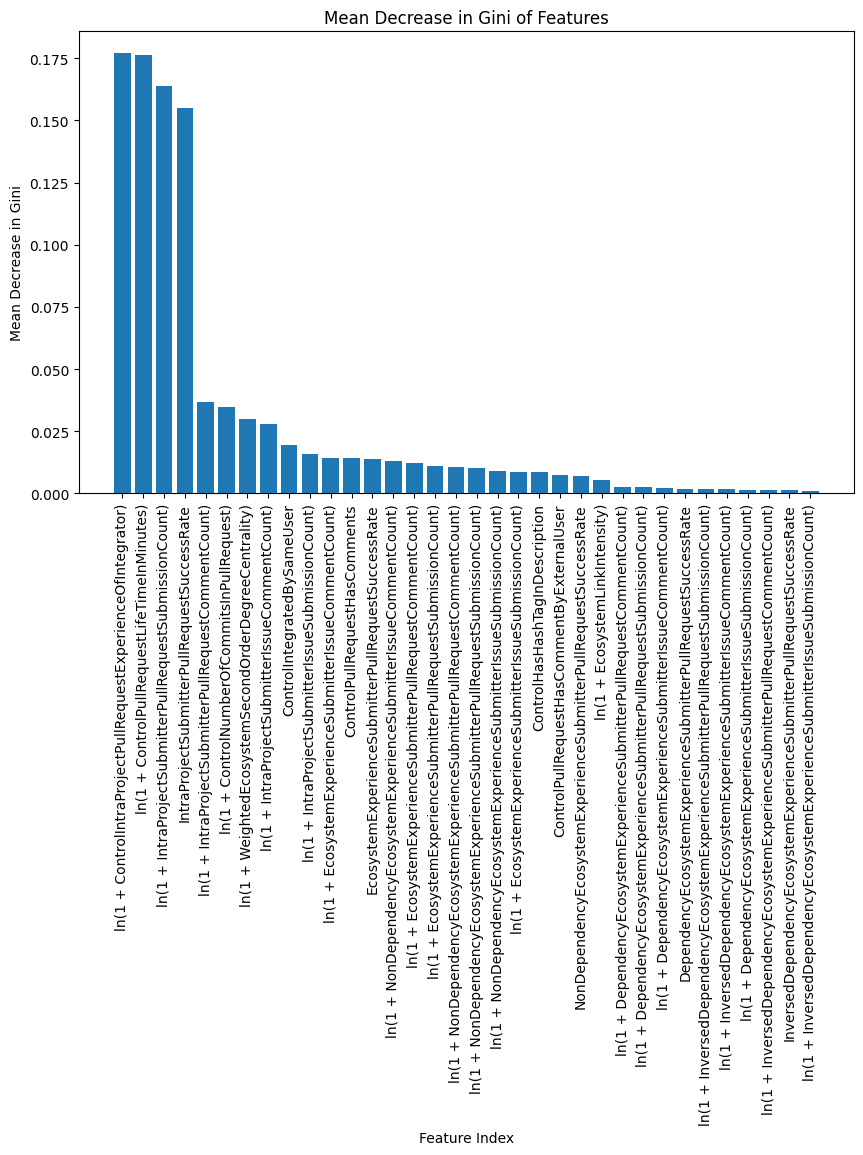

In [16]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [17]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.17698263992856605
ln(1 + ControlPullRequestLifeTimeInMinutes): 0.17643413151215362
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.16373448215215364
IntraProjectSubmitterPullRequestSuccessRate: 0.15517133810638284
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.03674182068357363
ln(1 + ControlNumberOfCommitsInPullRequest): 0.03459862608681086
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.030021603146977254
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.027727729069977006
ControlIntegratedBySameUser: 0.01959357947494572
ln(1 + IntraProjectSubmitterIssueSubmissionCount): 0.01576090597222648
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.014104203936777452
ControlPullRequestHasComments: 0.01403074394506453
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.013946999873665789
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.013029051557967982
ln(1 + EcosystemExp

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [18]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50

random_state=50

random_state=50

random_state=50

random_state=50

metrics={'accuracy': 0.8597523886762805, 'precision': 0.8945984220109245, 'recall': 0.9480571327182399, 'f1': 0.9205523112870633}


Confusion matrix:
[[  7455  15109]
 [  7026 128238]]


Classification report:

              precision    recall  f1-score   support

       False       0.51      0.33      0.40     22564
        True       0.89      0.95      0.92    135264

    accuracy                           0.86    157828
   macro avg       0.70      0.64      0.66    157828
weighted avg       0.84      0.86      0.85    157828


metrics={'accuracy': 0.8612784884715543, 'precision': 0.8971002833257546, 'recall': 0.9469432362779776, 'f1': 0.9213481531508878}


Confusion matrix:
[[  7697  14709]
 [  7185 128236]]


Classification report:

              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22406
        True       0.90      0.95      0.92    135421

    accuracy                           0.86    157827
   macro avg       0.71      0.65      0.67    157827
weighted avg       0.84      0.86      0.85    157827


metrics={'accuracy': 0.860087310789662, 'precision': 0.8953936886826732, 'recall': 0.9474158964879852, 'f1': 0.9206705034523887}


Confusion matrix:
[[  7607  14970]
 [  7112 128138]]


Classification report:

              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22577
        True       0.90      0.95      0.92    135250

    accuracy                           0.86    157827
   macro avg       0.71      0.64      0.66    157827
weighted avg       0.84      0.86      0.85    157827


metrics={'accuracy': 0.8603217446951409, 'precision': 0.895546496423352, 'recall': 0.9474256546826454, 'f1': 0.9207558835476345}


Confusion matrix:
[[  7709  14938]
 [  7107 128073]]


Classification report:

              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22647
        True       0.90      0.95      0.92    135180

    accuracy                           0.86    157827
   macro avg       0.71      0.64      0.67    157827
weighted avg       0.84      0.86      0.85    157827


metrics={'accuracy': 0.8604231215191317, 'precision': 0.8950724192354428, 'recall': 0.9481849185858122, 'f1': 0.9208634644192739}


Confusion matrix:
[[  7629  15025]
 [  7004 128169]]


Classification report:

              precision    recall  f1-score   support

       False       0.52      0.34      0.41     22654
        True       0.90      0.95      0.92    135173

    accuracy                           0.86    157827
   macro avg       0.71      0.64      0.67    157827
weighted avg       0.84      0.86      0.85    157827


Performance of 'FeatureGroups.Control'
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
f1_scores=[0.9205523112870633, 0.9213481531508878, 0.9206705034523887, 0.9207558835476345, 0.9208634644192739]
f1_mean=0.9208380631714496, f1_std=0.00027470744437194

Reverse ablation with "FeatureGroups.Intra", including: ['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)'].


random_state=52

random_state=52

random_state=52

random_state=52

random_state=52

metrics={'accuracy': 0.8655046348216718, 'precision': 0.882435691318328, 'recall': 0.972844830769458, 'f1': 0.9254374102084043}


Confusion matrix:
[[  4870  17550]
 [  3677 131730]]


Classification report:

              precision    recall  f1-score   support

       False       0.57      0.22      0.31     22420
        True       0.88      0.97      0.93    135407

    accuracy                           0.87    157827
   macro avg       0.73      0.60      0.62    157827
weighted avg       0.84      0.87      0.84    157827


metrics={'accuracy': 0.8643966849988595, 'precision': 0.8813701142654412, 'recall': 0.9728106274982083, 'f1': 0.9248356372218476}


Confusion matrix:
[[  4759  17722]
 [  3680 131667]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.21      0.31     22481
        True       0.88      0.97      0.92    135347

    accuracy                           0.86    157828
   macro avg       0.72      0.59      0.62    157828
weighted avg       0.84      0.86      0.84    157828


metrics={'accuracy': 0.8623049288144614, 'precision': 0.8794473021486363, 'recall': 0.9723559294420829, 'f1': 0.9235709110859457}


Confusion matrix:
[[  4790  17999]
 [  3733 131305]]


Classification report:

metrics={'accuracy': 0.8646809481267463, 'precision': 0.8822000401956187, 'recall': 0.9721465535697148, 'f1': 0.9249918343407241}


Confusion matrix:
[[  4784  17584]
 [  3773 131686]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.21      0.31     22789
        True       0.88      0.97      0.92    135038

    accuracy                           0.86    157827
   macro avg       0.72      0.59      0.61    157827
weighted avg       0.83      0.86      0.83    157827


              precision    recall  f1-score   support

       False       0.56      0.21      0.31     22368
        True       0.88      0.97      0.92    135459

    accuracy                           0.86    157827
   macro avg       0.72      0.59      0.62    157827
weighted avg       0.84      0.86      0.84    157827


metrics={'accuracy': 0.8627421163679219, 'precision': 0.8793396504189084, 'recall': 0.9731036678836171, 'f1': 0.9238486605055665}


Confusion matrix:
[[  4759  18031]
 [  3632 131405]]


Classification report:

              precision    recall  f1-score   support

       False       0.57      0.21      0.31     22790
        True       0.88      0.97      0.92    135037

    accuracy                           0.86    157827
   macro avg       0.72      0.59      0.61    157827
weighted avg       0.83      0.86      0.83    157827


Performance of 'FeatureGroups.Intra'
['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
f1_scores=[0.9254374102084043, 0.9248356372218476, 0.9235709110859457, 0.9249918343407241, 0.9238486605055665]
f1_mean=0.9245368906724976, f1_std=0.0007090748903841645

Reverse ablation with "FeatureGroups.Eco", including: ['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)'].


random_state=54

random_state=54

random_state=54

random_state=54

random_state=54

metrics={'accuracy': 0.8543731150366222, 'precision': 0.8650362142323557, 'recall': 0.9836971375807941, 'f1': 0.9205585510853034}


Confusion matrix:
[[  1676  20777]
 [  2207 133168]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.07      0.13     22453
        True       0.87      0.98      0.92    135375

    accuracy                           0.85    157828
   macro avg       0.65      0.53      0.52    157828
weighted avg       0.80      0.85      0.81    157828


metrics={'accuracy': 0.8545812820366604, 'precision': 0.8649054201527828, 'recall': 0.9840799402812987, 'f1': 0.9206520423862125}


Confusion matrix:
[[  1729  20797]
 [  2154 133147]]


Classification report:

metrics={'accuracy': 0.853624538260247, 'precision': 0.863904941237582, 'recall': 0.9841558672110776, 'f1': 0.9201181181319632}


Confusion matrix:
[[  1675  20960]
 [  2142 133050]]


Classification report:

              precision    recall  f1-score   support

       False       0.45      0.08      0.13     22526
        True       0.86      0.98      0.92    135301

    accuracy                           0.85    157827
   macro avg       0.66      0.53      0.53    157827
weighted avg       0.81      0.85      0.81    157827


metrics={'accuracy': 0.8530099412648026, 'precision': 0.8638549831662962, 'recall': 0.9833386355733448, 'f1': 0.9197324761868514}


Confusion matrix:
[[  1717  20947]
 [  2252 132911]]


Classification report:

              precision    recall  f1-score   support

       False       0.44      0.07      0.13     22635
        True       0.86      0.98      0.92    135192

    accuracy                           0.85    157827
   macro avg       0.65      0.53      0.52    157827
weighted avg       0.80      0.85      0.81    157827


              precision    recall  f1-score   support

       False       0.43      0.08      0.13     22664
        True       0.86      0.98      0.92    135163

    accuracy                           0.85    157827
   macro avg       0.65      0.53      0.52    157827
weighted avg       0.80      0.85      0.81    157827


metrics={'accuracy': 0.8535865219512504, 'precision': 0.8641083081718126, 'recall': 0.9838825347301803, 'f1': 0.9201139451431575}


Confusion matrix:
[[  1642  20928]
 [  2180 133077]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.07      0.12     22570
        True       0.86      0.98      0.92    135257

    accuracy                           0.85    157827
   macro avg       0.65      0.53      0.52    157827
weighted avg       0.80      0.85      0.81    157827


Performance of 'FeatureGroups.Eco'
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9205585510853034, 0.9206520423862125, 0.9201181181319632, 0.9197324761868514, 0.9201139451431575]
f1_mean=0.9202350265866975, f1_std=0.00033450126618201785

Reverse ablation with "FeatureGroups.DEco", including: ['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)'].


random_state=56

random_state=56

random_state=56

random_state=56

random_state=56

metrics={'accuracy': 0.8571356159870238, 'precision': 0.8586412062345852, 'recall': 0.9977102845156144, 'f1': 0.9229665464086585}


Confusion matrix:
[[   202  22238]
 [   310 135078]]


Classification report:

              precision    recall  f1-score   support

       False       0.39      0.01      0.02     22440
        True       0.86      1.00      0.92    135388

    accuracy                           0.86    157828
   macro avg       0.63      0.50      0.47    157828
weighted avg       0.79      0.86      0.79    157828


metrics={'accuracy': 0.8554810013495789, 'precision': 0.8569539875545837, 'recall': 0.9977502479167591, 'f1': 0.9220079807695596}


Confusion matrix:
[[   196  22505]
 [   304 134822]]


Classification report:

              precision    recall  f1-score   support

       False       0.39      0.01      0.02     22701
        True       0.86      1.00      0.92    135126

    accuracy                           0.86    157827
   macro avg       0.62      0.50      0.47    157827
weighted avg       0.79      0.86      0.79    157827


metrics={'accuracy': 0.8580597743098456, 'precision': 0.8594526572688792, 'recall': 0.99787478969273, 'f1': 0.9235055897397373}


Confusion matrix:
[[   197  22114]
 [   288 135228]]


Classification report:

metrics={'accuracy': 0.8561526228085182, 'precision': 0.8577169344634421, 'recall': 0.9975891140363852, 'f1': 0.9223805176911426}


Confusion matrix:
[[   230  22377]
 [   326 134894]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.01      0.02     22311
        True       0.86      1.00      0.92    135516

    accuracy                           0.86    157827
   macro avg       0.63      0.50      0.47    157827
weighted avg       0.80      0.86      0.80    157827


              precision    recall  f1-score   support

       False       0.41      0.01      0.02     22607
        True       0.86      1.00      0.92    135220

    accuracy                           0.86    157827
   macro avg       0.64      0.50      0.47    157827
weighted avg       0.79      0.86      0.79    157827


metrics={'accuracy': 0.8549741172296248, 'precision': 0.8563928841545961, 'recall': 0.9978228350538367, 'f1': 0.9217140883174806}


Confusion matrix:
[[   194  22595]
 [   294 134744]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.01      0.02     22789
        True       0.86      1.00      0.92    135038

    accuracy                           0.85    157827
   macro avg       0.63      0.50      0.47    157827
weighted avg       0.79      0.85      0.79    157827


Performance of 'FeatureGroups.DEco'
['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9229665464086585, 0.9220079807695596, 0.9235055897397373, 0.9223805176911426, 0.9217140883174806]
f1_mean=0.9225149445853159, f1_std=0.0006483480070023076

Reverse ablation with "FeatureGroups.IDEco", including: ['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)

random_state=58

random_state=58

random_state=58

random_state=58

random_state=58

metrics={'accuracy': 0.8565780469878602, 'precision': 0.857732744655846, 'recall': 0.9982182595130895, 'f1': 0.9226585029179023}


Confusion matrix:
[[   172  22395]
 [   241 135020]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.01      0.01     22567
        True       0.86      1.00      0.92    135261

    accuracy                           0.86    157828
   macro avg       0.64      0.50      0.47    157828
weighted avg       0.79      0.86      0.79    157828


metrics={'accuracy': 0.8556203944825663, 'precision': 0.8569331842325971, 'recall': 0.9980020867094368, 'f1': 0.922103449572521}


Confusion matrix:
[[   169  22517]
 [   270 134871]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.01      0.01     22686
        True       0.86      1.00      0.92    135141

    accuracy                           0.86    157827
   macro avg       0.62      0.50      0.47    157827
weighted avg       0.79      0.86      0.79    157827


metrics={'accuracy': 0.8562856798900061, 'precision': 0.8575003970144514, 'recall': 0.9981588423628929, 'f1': 0.922498684507254}


Confusion matrix:
[[   153  22433]
 [   249 134992]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.01      0.01     22586
        True       0.86      1.00      0.92    135241

    accuracy                           0.86    157827
   macro avg       0.62      0.50      0.47    157827
weighted avg       0.79      0.86      0.79    157827


metrics={'accuracy': 0.8580407661553473, 'precision': 0.8593630864636812, 'recall': 0.9980003099150685, 'f1': 0.9235076219251975}


Confusion matrix:
[[   172  22134]
 [   271 135250]]


Classification report:

metrics={'accuracy': 0.8553732884740887, 'precision': 0.8567235486207291, 'recall': 0.997972232911992, 'f1': 0.9219693292220179}


Confusion matrix:
[[   151  22552]
 [   274 134850]]


Classification report:

              precision    recall  f1-score   support

       False       0.39      0.01      0.02     22306
        True       0.86      1.00      0.92    135521

    accuracy                           0.86    157827
   macro avg       0.62      0.50      0.47    157827
weighted avg       0.79      0.86      0.80    157827


              precision    recall  f1-score   support

       False       0.36      0.01      0.01     22703
        True       0.86      1.00      0.92    135124

    accuracy                           0.86    157827
   macro avg       0.61      0.50      0.47    157827
weighted avg       0.78      0.86      0.79    157827


Performance of 'FeatureGroups.IDEco'
['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9226585029179023, 0.922103449572521, 0.922498684507254, 0.9235076219251975, 0.9219693292220179]
f1_mean=0.9225475176289784, f1_std=0.0005418488609312877

Reverse ablation with "FeatureGroups.NDEco", including: ['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssu

random_state=60

random_state=60

random_state=60

random_state=60

random_state=60

metrics={'accuracy': 0.8536878987752412, 'precision': 0.863832988527365, 'recall': 0.9845076981070713, 'f1': 0.9202310301707164}


Confusion matrix:
[[  1538  20996]
 [  2096 133197]]


Classification report:

metrics={'accuracy': 0.8548537322511357, 'precision': 0.8644969762181012, 'recall': 0.9852040627885503, 'f1': 0.9209119909408532}


Confusion matrix:
[[  1547  20905]
 [  2003 133372]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.07      0.12     22534
        True       0.86      0.98      0.92    135293

    accuracy                           0.85    157827
   macro avg       0.64      0.53      0.52    157827
weighted avg       0.80      0.85      0.81    157827


              precision    recall  f1-score   support

       False       0.44      0.07      0.12     22452
        True       0.86      0.99      0.92    135375

    accuracy                           0.85    157827
   macro avg       0.65      0.53      0.52    157827
weighted avg       0.80      0.85      0.81    157827


metrics={'accuracy': 0.8534670654129812, 'precision': 0.8631426127083711, 'recall': 0.9851243092900944, 'f1': 0.9201081943767941}


Confusion matrix:
[[  1525  21116]
 [  2011 133176]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.07      0.12     22641
        True       0.86      0.99      0.92    135187

    accuracy                           0.85    157828
   macro avg       0.65      0.53      0.52    157828
weighted avg       0.80      0.85      0.80    157828


metrics={'accuracy': 0.8550184695901208, 'precision': 0.8647350510452114, 'recall': 0.9851278605238478, 'f1': 0.9210137523472881}


Confusion matrix:
[[  1538  20868]
 [  2014 133407]]


Classification report:

metrics={'accuracy': 0.8527438271018267, 'precision': 0.8623399358122346, 'recall': 0.9851198411993008, 'f1': 0.9196499877267527}


Confusion matrix:
[[  1583  21232]
 [  2009 133003]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.07      0.12     22406
        True       0.86      0.99      0.92    135421

    accuracy                           0.86    157827
   macro avg       0.65      0.53      0.52    157827
weighted avg       0.80      0.86      0.81    157827


              precision    recall  f1-score   support

       False       0.44      0.07      0.12     22815
        True       0.86      0.99      0.92    135012

    accuracy                           0.85    157827
   macro avg       0.65      0.53      0.52    157827
weighted avg       0.80      0.85      0.80    157827


Performance of 'FeatureGroups.NDEco'
['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.9202310301707164, 0.9209119909408532, 0.9201081943767941, 0.9210137523472881, 0.9196499877267527]
f1_mean=0.9203829911124808, f1_std=0.0005125621700844762

Reverse ablation with "FeatureGroups.Coll", including: ['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)'].


random_state=62

random_state=62

random_state=62

random_state=62

random_state=62

metrics={'accuracy': 0.8401604288239655, 'precision': 0.8651811988017285, 'recall': 0.9639289063480695, 'f1': 0.9118895187401113}


Confusion matrix:
[[  2058  20342]
 [  4885 130542]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.09      0.14     22400
        True       0.87      0.96      0.91    135427

    accuracy                           0.84    157827
   macro avg       0.58      0.53      0.53    157827
weighted avg       0.78      0.84      0.80    157827


metrics={'accuracy': 0.8390262756055681, 'precision': 0.8641132533154828, 'recall': 0.9637574565909981, 'f1': 0.9112193621883801}


Confusion matrix:
[[  2041  20503]
 [  4903 130380]]


Classification report:

              precision    recall  f1-score   support

       False       0.29      0.09      0.14     22544
        True       0.86      0.96      0.91    135283

    accuracy                           0.84    157827
   macro avg       0.58      0.53      0.52    157827
weighted avg       0.78      0.84      0.80    157827


metrics={'accuracy': 0.8390452837600664, 'precision': 0.8633774834437086, 'recall': 0.9646818555160089, 'f1': 0.9112227103231602}


Confusion matrix:
[[  2054  20630]
 [  4773 130370]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.09      0.14     22684
        True       0.86      0.96      0.91    135143

    accuracy                           0.84    157827
   macro avg       0.58      0.53      0.53    157827
weighted avg       0.78      0.84      0.80    157827


metrics={'accuracy': 0.83933674212904, 'precision': 0.8636868994361648, 'recall': 0.9648182510405192, 'f1': 0.9114558780907684}


Confusion matrix:
[[  1960  20598]
 [  4759 130510]]


Classification report:

metrics={'accuracy': 0.8393440961046202, 'precision': 0.8633782495896648, 'recall': 0.9651317639051241, 'f1': 0.9114238005742991}


Confusion matrix:
[[  2019  20643]
 [  4713 130453]]


Classification report:

              precision    recall  f1-score   support

       False       0.29      0.09      0.13     22558
        True       0.86      0.96      0.91    135269

    accuracy                           0.84    157827
   macro avg       0.58      0.53      0.52    157827
weighted avg       0.78      0.84      0.80    157827


              precision    recall  f1-score   support

       False       0.30      0.09      0.14     22662
        True       0.86      0.97      0.91    135166

    accuracy                           0.84    157828
   macro avg       0.58      0.53      0.52    157828
weighted avg       0.78      0.84      0.80    157828


Performance of 'FeatureGroups.Coll'
['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)']
f1_scores=[0.9118895187401113, 0.9112193621883801, 0.9112227103231602, 0.9114558780907684, 0.9114238005742991]
f1_mean=0.911442253983344, f1_std=0.0002443162206009794



In [19]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.9205523112870633, 0.9213481531508878, 0.9206705034523887, 0.9207558835476345, 0.9208634644192739]
f1_mean=0.9208380631714496, f1_std=0.00027470744437194

Cluster 'FeatureGroups.Intra':
f1_scores=[0.9254374102084043, 0.9248356372218476, 0.9235709110859457, 0.9249918343407241, 0.9238486605055665]
f1_mean=0.9245368906724976, f1_std=0.0007090748903841645

Cluster 'FeatureGroups.Eco':
f1_scores=[0.9205585510853034, 0.9206520423862125, 0.9201181181319632, 0.9197324761868514, 0.9201139451431575]
f1_mean=0.9202350265866975, f1_std=0.00033450126618201785

Cluster 'FeatureGroups.DEco':
f1_scores=[0.9229665464086585, 0.9220079807695596, 0.9235055897397373, 0.9223805176911426, 0.9217140883174806]
f1_mean=0.9225149445853159, f1_std=0.0006483480070023076

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.9226585029179023, 0.922103449572521, 0.922498684507254, 0.9235076219251975, 0.9219693292220179]
f1_mean=0.9225475176289784, 

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [20]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.8569980332921068.
{
    "accuracy": 0.7546316242998707,
    "precision": 0.8569676189350162,
    "recall": 0.8568789714792375,
    "f1": 0.8569232929145146
}


In [21]:
import datetime

print(datetime.datetime.now())

2024-02-21 19:20:08.862810
